<font style='font-size:24px; font-weight:bold'>Определение дипфейков по фотографии.</font>

**Годовой проект по первому курсу магистерской подготовки МОВС ВШЭ.**


<font style='font-size:18px; font-weight:bold'>    
<br> Команда: Тимур Ермешев.
<br> Куратор: Вячеслав Пирогов.    
</font>


<font style='font-size:24px; font-weight:bold'>Разведочный анализ данных.</font>


# **Данные:**

Данные состоят из двух датасетов:

[**FaceForensics++**](https://github.com/ondyari/FaceForensics/tree/master/dataset)  - датасет, который состоит из оригинальных видео, которые были изменены следующими методами

    Deepfakes 
    Face2Face
    FaceSwap
    NeuralTextures.

Видеофалы аккумулированы локально в папке проекта datasets:

    datasets/videos/faceforensics/real - 363 оригинальных видеофайла с YouTube без изменений.
    datasets/videos/faceforensics/fake - 3068 видеофайлов с измененным лицом (дипфейк).

Все видеофайлы имеют следущие параметры:

    ширина кадра - 1920
    высота кадра - 1080
    частота кадров - 24 кадра/с


[**Celeb-DF**](https://paperswithcode.com/dataset/celeb-df)  - датасет, который состоит из оригинальных видео, которые были изменены.

Видеофалы аккумулированы локально в папке проекта datasets:

    datasets/videos/celebdf_2/real - 300 оригинальных видеофайла с YouTube без изменений.
    datasets/videos/celebdf_2/fake - 5639 видеофайлов с измененным лицом (дипфейк).

Все видеофайлы имеют разную ширину и высоту кадра, но при этом частота кадров = 30 кадров/с.







# Формирование датасета 

1. Объединение двух датасетов в один.
2. Вытащить по 4 кадра с каждого видео для формирования датасета.
3. Перед вытаскиванием кадров из видео, произвести разделение на:

    *    Train - 60%
    *    Validation - 20%
    *    Test - 20%
    
Разделение необходимо произвести до раскадровки, чтобы кадры из одного видео не смогли попасть во разные выборки, для исключения утечки.

Для разделения написан код, который:

1. Создает необходимые директории в datasets/frames/
2. Собирает все названия видеофайлов и пути к ним.
3. Модулем train_test_split из sklearn разбивает все названия видеофайлов на 3 выборки (train, val, test)
4. Обращаясь по пути к файлу, берет из него 4 кадра случайным образом
5. Записывает их в соответствующую директорию
6. Создает для каждого кадра уникальное имя модулем uuid, прибавив к нему название датасета (faceforensics, celebdf_2) и класс объекта (real, fake)
7. Записывает новые имена файлов в names.csv

В итоге новый датасет имеет 37480 файлов.

При необходимости датасет может быть увеличен.

При высоких показателях метрики модель может быть испытана на другом датасете. Например с ресурса [Roboflow](https://roboflow.com/) 


In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import random
import uuid

from tqdm.autonotebook import trange

from sklearn.model_selection import train_test_split
RANDOM_STATE = 12345
random.seed(RANDOM_STATE)

C:\Users\t.ermeshev\AppData\Local\Temp\ipykernel_2948\3654892262.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [2]:
%%script false # Для отключения выполнения ячейки

videos_folder = 'videos'
datasets_folder = 'datasets'
frames_folder = 'frames'
phases = ['train', 'val', 'test']
classes = ['real', 'fake']

folders_path = {'datasets': os.path.join(os.getcwd(), datasets_folder),
                'videos':os.path.join(os.getcwd(), datasets_folder, videos_folder),
                'frames': os.path.join(os.getcwd(), datasets_folder, frames_folder)
               }


for phase in phases:
    folders_path[phase] = os.path.join(folders_path['frames'], phase)
    for class_name in classes:
        folders_path[phase+'_'+class_name] = os.path.join(folders_path[phase], class_name)
        


# check input folder
if not os.path.isdir(folders_path['videos']):
    name = os.path.split(folders_path['videos'])[-1]
    print(f'The folder "{name}" does not exist. Please check the path')
#     return

# Create folders
for folder in folders_path.keys():
    if not os.path.isdir(folders_path[folder]):
        os.mkdir(folders_path[folder])
        print(f'The folder "{os.path.split(folder)[-1]}" does not exist. The folder was created')

# datasets_videos = os.listdir(folders_path['videos'])

videos_path = defaultdict(list)


# datasets_videos = os.listdir(folders_path['videos'])
# Список адресов папок
folders = []
for dataset in os.listdir(folders_path['videos']):
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(folders_path['videos'], dataset)):
        folders.append(dirpath)

        
# Все адреса файлов в dict по категориям 'fake' и 'real'
for folder in folders:
    if os.path.split(folder)[-1] in classes:
        for name in os.listdir(folder):
            class_name = os.path.split(folder)[-1]
            videos_path[class_name].append(os.path.join(folder,name))


def split_dataset(path_dict):
    dataset_path = defaultdict(dict)
    for name in classes:        
        dataset_path['train'][name], test = train_test_split(path_dict[name], test_size=0.4, random_state=RANDOM_STATE)
        dataset_path['val'][name], dataset_path['test'][name] = train_test_split(test, test_size=0.5, random_state=RANDOM_STATE)
    return dataset_path

print('-'*100)
print("splitting dataset..............")

dataset_path = split_dataset(videos_path)


def get_frames(path, new_path, nums=4):
    cap = cv2.VideoCapture(path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i, frame_number in enumerate(random.sample(range(1, frame_count), nums)):
        cap.set(1, frame_number)
        ret, frame = cap.read()
        frame_path = new_path + '-' + str(i) + '.jpg'
        cv2.imwrite(frame_path, frame)

print('-'*100)
print("Getting frames..............")

file_names = []
count = 0
for key1, values1 in dataset_path.items():
    for key2, values2 in values1.items():
        for path in values2:
            dataset_name = os.path.split(os.path.split(os.path.split(path)[0])[0])[-1]
            unique_filename = str(uuid.uuid4().hex)[:10]
            path_to = os.path.join(folders_path['frames'], key1, key2, dataset_name+'_'+key2+'_'+unique_filename)
            file_names.append(dataset_name+'_'+key2+'_'+unique_filename)
            get_frames(path, path_to, nums=4)
            count +=1
            if count % 500 == 0:
                print(count)
#             print(dataset_name+'_'+key2+'_'+unique_filename)
#             print(path)

df = pd.DataFrame({'file_names':file_names})
df.to_csv('names.csv', index=False)

Couldn't find program: 'false'


# Напечатаем несколько фотографий каждого класса

In [3]:
real_path = os.path.join(os.getcwd(), 'datasets', 'frames', 'train', 'real')
fake_path = os.path.join(os.getcwd(), 'datasets', 'frames', 'train', 'fake')

In [4]:
def show_frames(path, title='Title', rows=3, cols=2):
    nums = rows * cols
    files_lst = random.sample(os.listdir(path), nums)

    fig, axx = plt.subplots(rows, cols, figsize=(5 * rows, 15))
    plt.suptitle(title, size=16)
    counter = 0
    for row in range(rows):
        for col in range(cols):
            img = cv2.imread(os.path.join(path, files_lst[counter]))
            height, width, channels = img.shape
            resolution = f'resolution {width}x{height}'
            axx[row][col].imshow(img)
            axx[row][col].set_title(f'{files_lst[counter]}\n{resolution}')
            counter += 1
    plt.show()

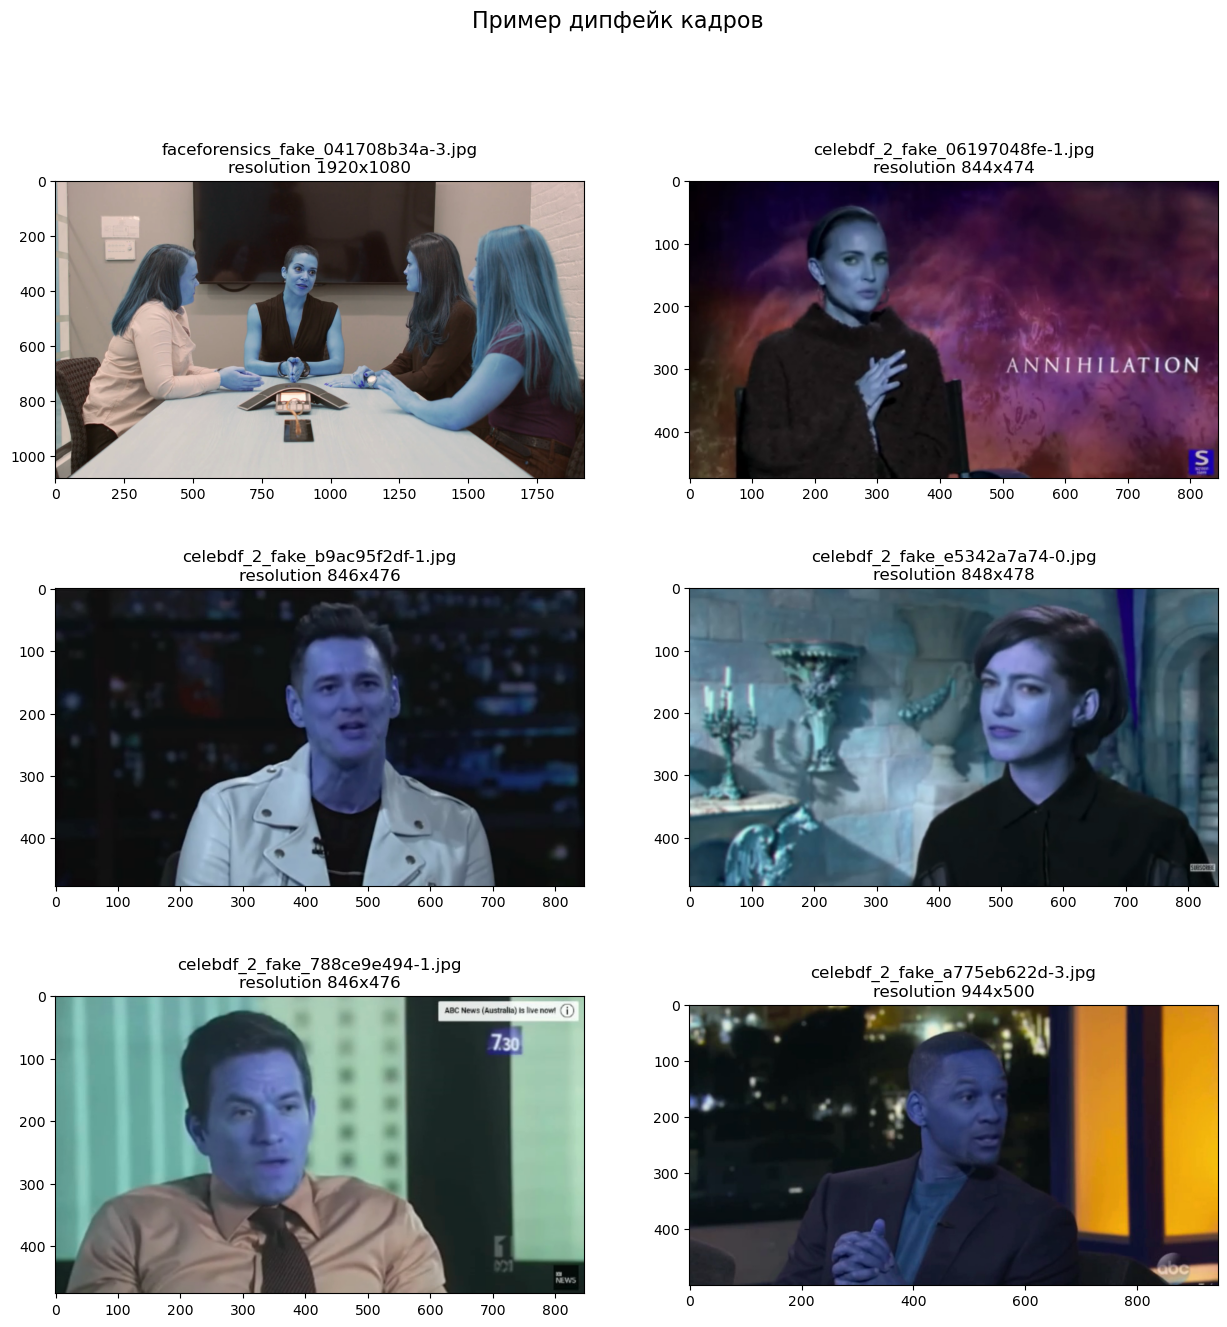

In [5]:
show_frames(path=fake_path, title='Пример дипфейк кадров')

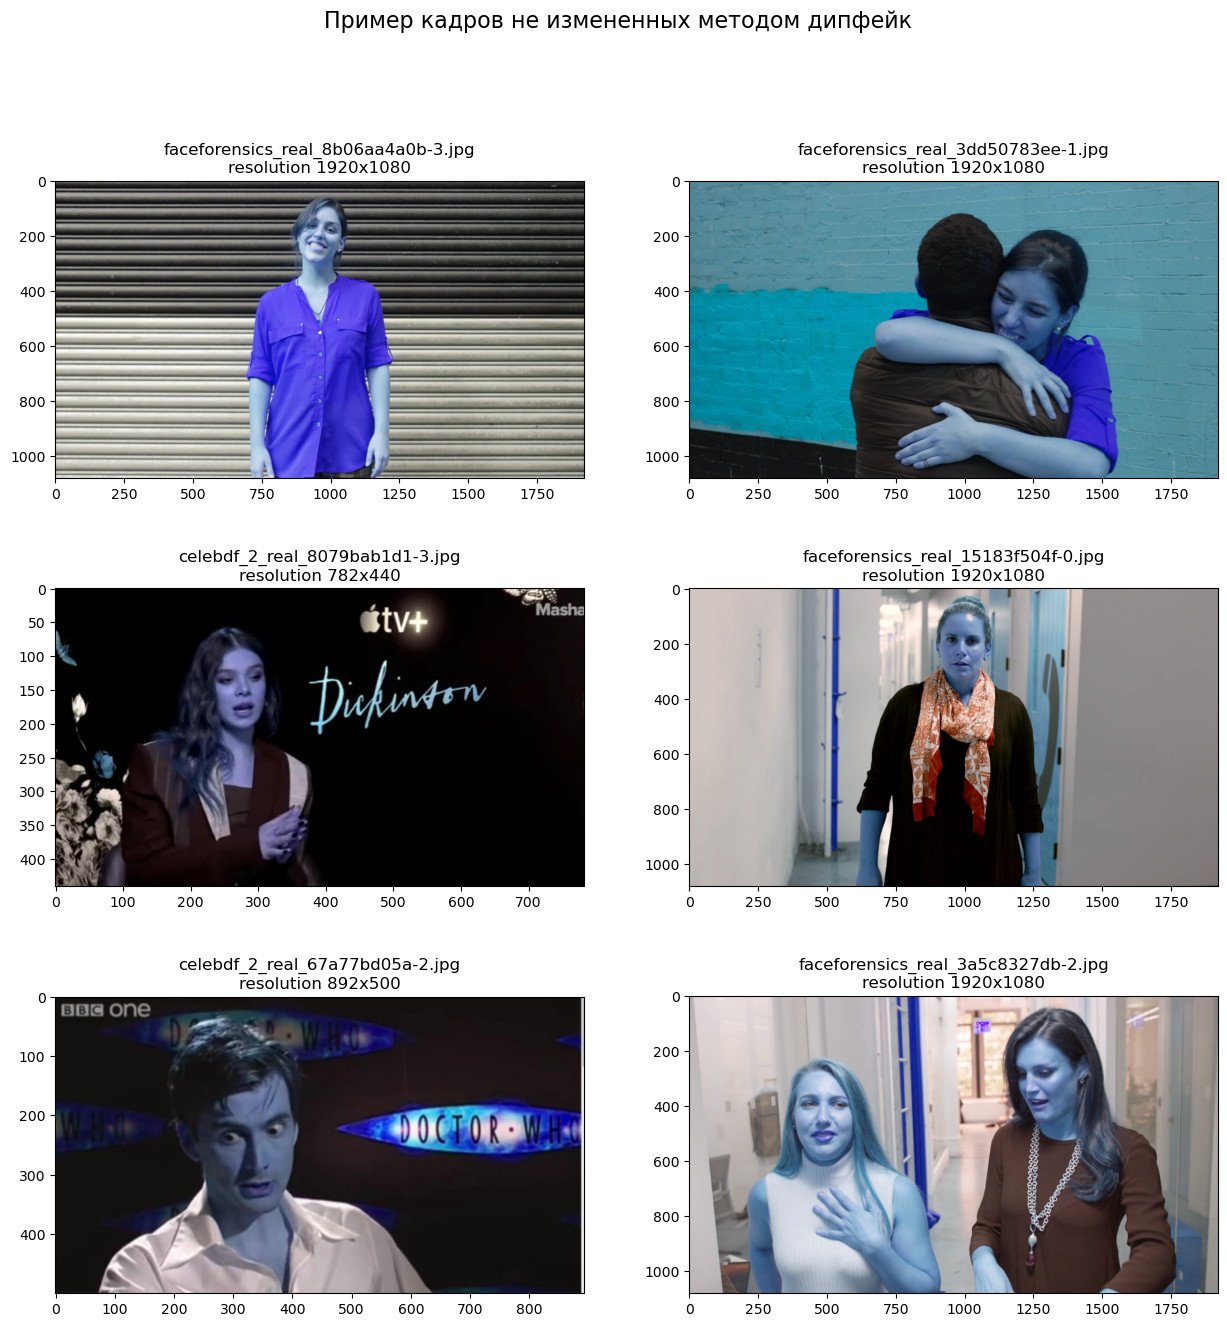

In [6]:
show_frames(path=real_path, title='Пример кадров не измененных методом дипфейк')

# Подсчет среднего и дисперсии для каждого канала отдельно

In [7]:
names_dict = {'name': [],
              'phase': [],
              'class': [],
#               'link': [],
             }
phases = ['train', 'val', 'test']
classes = ['real', 'fake']
frames_path = os.path.join(os.getcwd(), 'datasets', 'frames')

In [8]:
for phase in phases:
    for class_name in classes:
        link = os.path.join(frames_path, phase, class_name)
        names = os.listdir(link)
        names_dict['name'].extend(names)
#         links = [os.path.join(link, name) for name in names]
#         names_dict['link'].extend(links)
        names_dict['phase'].extend([phase] * len(names))
        names_dict['class'].extend([class_name] * len(names))

In [9]:
df = pd.DataFrame(names_dict)
df.to_csv('dataset_names.csv', index=False)
df.head()

,name,phase,class
0,celebdf_2_real_013a88f20d-0.jpg,train,real
1,celebdf_2_real_013a88f20d-1.jpg,train,real
2,celebdf_2_real_013a88f20d-2.jpg,train,real
3,celebdf_2_real_013a88f20d-3.jpg,train,real
4,celebdf_2_real_01400a5c2e-0.jpg,train,real


In [10]:
# %%script false
# get image links

imgs_path = []

for phase in ['train']:
    for class_name in classes:
        link = os.path.join(frames_path, phase, class_name)
        names = os.listdir(link)
        imgs_path.extend([os.path.join(link, name) for name in names if '0' in name.split('-')[-1]])
len(imgs_path)

5621

In [11]:
path_split = np.array_split(imgs_path, 1000)
len(path_split)

1000

In [13]:
total_sum = np.array([0.0, 0.0, 0.0])
total_count = 0
total_sq_sum = np.array([0.0, 0.0, 0.0])

pbar = trange(len(path_split), desc='iteration')

for i in pbar:
    imgs_paths = path_split[i]
    rgb_values = np.concatenate(
        [Image.open(img).getdata() for img in imgs_paths], 
        axis = 0
    ) / 255.
    
    total_sum += np.sum(rgb_values, axis=0)
    total_count += len(rgb_values)
    total_sq_sum += np.sum(rgb_values**2, axis=0)


mean_rgb = total_sum / total_count
var_rgb  = (total_sq_sum / total_count) - (mean_rgb ** 2)
std_rgb  = np.sqrt(var_rgb)


print('Mean for 3 channels: R, G, B' , mean_rgb)
print('Variance for 3 channels: R, G, B' , var_rgb)
print('Standart deviation for 3 channels: R, G, B' , std_rgb)


Mean for 3 channels: R, G, B [0.4223103  0.40645579 0.40156024]
Variance for 3 channels: R, G, B [0.07076343 0.06958127 0.0741205 ]
Standart deviation for 3 channels: R, G, B [0.26601396 0.26378262 0.2722508 ]
